In [43]:
#Import packages
import numpy as np
import pyspark.sql.functions as F
import snowflake.connector
import pandas as pd
import spacy
#from sparknlp.base import Finisher, DocumentAssembler
#from sparknlp.annotator import  Normalizer, LemmatizerModel, StopWordsCleaner, Tokenizer
#from pyspark.ml import Pipeline
#from pyspark.ml.feature import CountVectorizer, VectorAssembler, HashingTF, IDF, Tokenizer
#from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
#import re
from sklearn.model_selection import train_test_split
from scipy import sparse
from sklearn.linear_model import LogisticRegression

# Binary Relevance
from sklearn.multiclass import OneVsRestClassifier

# Performance metric
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score, confusion_matrix, roc_curve, auc

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [2]:
#SPARK connection info
sfOptions = {
  'sfURL' : 'powerreviews.snowflakecomputing.com',
  'sfAccount' : 'powerreviews',
  'sfUser' : 'APP_SPARK_PROD',
  'sfPassword' : '>6txhcQ*7&^Qrq`j',
  'sfDatabase' : 'ANALYTICS_PROD',
  'sfSchema' : 'ANALYTICS',
  'sfWarehouse' : 'LOWER_ENV_WAREHOUSE'
}
SNOWFLAKE_SOURCE_NAME = "net.snowflake.spark.snowflake"

#PYTHON connection info
conn = snowflake.connector.connect(
    account='powerreviews',
    database='analytics_prod',
    warehouse='LOWER_ENV_WAREHOUSE',
    user='APP_SPARK_PROD',
    password='>6txhcQ*7&^Qrq`j'
    )

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [3]:
#Use review data set to get observation codes bc they are already comma separated and less joins to perform
#Still need observation set though to get observation created date
#This is bc review could be from ages ago but we could have imported recently and moderated it
#Want to make sure we include as many observation labels as possible for most accurate model



VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [4]:
query = "select distinct r.ugc_id, r.created_date, r.review_headline, \
r.review_comments, r.review_rating, r.reviewer_nickname, r.locale, r.observations, \
ADD IN CASE WHEN HERE \
from analytics.review as r \
left join cdm.observation as o \
on r.ugc_id = o.ugc_id \
where contains(r.observations, 'PM') \
and r.locale in ('en_US','en_GB','en_CA') \
and o.created_date > '2020-09-23'  \
limit 100"

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [5]:
#Careful not to get CNR for NR
#CNR, NR, PM - contains(r.observations, ',NR,')
#NR, PM - substring(r.observations, 1, 2) = 'NR'
#CNR, PM - DONT WANT
#Careful not to get SSC for SC
#PM, SC - 
#PM, SSC - DONT WANT
#PM, SC, SSC
#18 labels total - not including PM (doesn't yet include NOLABEL label - 19 labels with that)
query_testing = "select distinct r.ugc_id, r.created_date, r.review_headline, \
r.review_comments, r.review_rating, r.reviewer_nickname, r.reviewer_location, r.observations, \
case when contains(r.observations, 'PM') then 1 else 0 end as PM, \
case when (contains(r.observations, ',NR,') or substring(r.observations, 1, 2) = 'NR')  then 1 else 0 end as NR, \
case when contains(r.observations, 'PII') then 1 else 0 end as PII, \
case when contains(r.observations, 'PR') then 1 else 0 end as PR, \
case when contains(r.observations, 'CS') then 1 else 0 end as CS, \
case when contains(r.observations, 'DC') then 1 else 0 end as DC, \
case when contains(r.observations, 'CR') then 1 else 0 end as CR, \
case when contains(r.observations, 'FRD') then 1 else 0 end as FRD, \
case when contains(r.observations, 'TST') then 1 else 0 end as TST, \
case when contains(r.observations, 'CC') then 1 else 0 end as CC, \
case when contains(r.observations, ',SC') then 1 else 0 end as SC, \
case when contains(r.observations, 'PIM') then 1 else 0 end as PIM, \
case when contains(r.observations, 'LC') then 1 else 0 end as LC, \
case when contains(r.observations, 'WEB') then 1 else 0 end as WEB, \
case when contains(r.observations, 'FL') then 1 else 0 end as FL, \
case when contains(r.observations, 'SA') then 1 else 0 end as SA, \
case when contains(r.observations, 'URL') then 1 else 0 end as URL, \
case when contains(r.observations, 'CV') then 1 else 0 end as CV, \
case when contains(r.observations, 'US') then 1 else 0 end as US \
from analytics.review as r \
where r.locale in ('en_US','en_GB','en_CA') \
and r.created_date > '2019-09-01'  \
and contains(r.observations, 'PM') \
limit 250000"

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [9]:
#pd.set_option('display.max_colwidth', -1)
#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)
reviews = pd.read_sql(query_testing, conn)
reviews.head(100)
#reviews.info()

#PULLING IN ALL REVIEWS SINCE '2019-09-01' (17,468,653) TAKES X MINS

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

       UGC_ID        CREATED_DATE  ... CV US
0   262848155 2019-11-23 10:31:12  ...  0  0
1   262854906 2019-11-23 16:49:58  ...  0  0
2   262769168 2019-11-23 23:13:56  ...  0  0
3   297103320 2019-11-23 17:25:44  ...  0  0
4   299257691 2019-11-23 17:25:44  ...  0  0
..        ...                 ...  ... .. ..
95  262011072 2019-11-23 01:49:28  ...  0  0
96  262057754 2019-11-23 15:41:58  ...  0  0
97  262751391 2019-11-23 18:18:37  ...  0  0
98  262020452 2019-11-23 06:16:56  ...  0  0
99  266831262 2019-11-23 16:00:00  ...  0  0

[100 rows x 27 columns]

In [10]:
reviews.loc[reviews['REVIEWER_LOCATION'] == 'US', 'REVIEWER_LOCATION'] = 'USA'

#reviews['REVIEWER_LOCATION'].head(500)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [8]:
#Use set_option so text doesn't truncate
#pd.set_option('display.max_colwidth', -1)
#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)
reviews['LABEL_SUM']= reviews.iloc[:, -18:-1].sum(axis=1)
reviews

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

           UGC_ID        CREATED_DATE  ... US LABEL_SUM
0       262848155 2019-11-23 10:31:12  ...  0         0
1       262854906 2019-11-23 16:49:58  ...  0         0
2       262769168 2019-11-23 23:13:56  ...  0         0
3       297103320 2019-11-23 17:25:44  ...  0         0
4       299257691 2019-11-23 17:25:44  ...  0         0
...           ...                 ...  ... ..       ...
249995  272242825 2020-04-09 08:56:09  ...  0         0
249996  272319032 2020-04-09 14:18:05  ...  0         0
249997  272319061 2020-04-09 15:57:17  ...  0         0
249998  272319082 2020-04-09 19:55:16  ...  0         0
249999  270577008 2020-04-09 11:37:56  ...  0         0

[250000 rows x 28 columns]

In [10]:
#LOOK AT OTHER LABELS - IF NONE THEN ADD NOLABEL = 1
#df['new column name'] = df['column name'].apply(lambda x: 'value if condition is met' if x condition else 'value if condition is not met')
reviews['NOLABEL'] = reviews['LABEL_SUM'].apply(lambda x: int(1) if x==0 else int(0))

#df.loc[df['set_of_numbers'] <= 4, 'equal_or_lower_than_4?'] = 'True' 
#reviews.loc[reviews['NOLABEL'] == 0, 'TEST'] = 1
#df['Fruit Total']= df.iloc[:, -4:-1].sum(axis=1)
reviews

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

           UGC_ID        CREATED_DATE  ... LABEL_SUM NOLABEL
0       281456347 2020-06-16 12:36:22  ...         0       1
1       281663273 2020-06-16 12:11:38  ...         0       1
2       281661361 2020-06-16 07:31:56  ...         0       1
3       281663375 2020-06-16 12:24:17  ...         0       1
4       281662853 2020-06-16 13:04:11  ...         0       1
...           ...                 ...  ...       ...     ...
499995  258929055 2019-10-07 10:54:46  ...         0       1
499996  258929104 2019-10-07 11:37:48  ...         0       1
499997  258928991 2019-10-07 13:07:49  ...         0       1
499998  258992068 2019-10-07 16:12:19  ...         0       1
499999  258992136 2019-10-07 13:45:07  ...         0       1

[500000 rows x 29 columns]

In [11]:
reviews2 = reviews.drop(['LABEL_SUM'], axis=1)
reviews2

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

           UGC_ID        CREATED_DATE  ... US NOLABEL
0       281456347 2020-06-16 12:36:22  ...  0       1
1       281663273 2020-06-16 12:11:38  ...  0       1
2       281661361 2020-06-16 07:31:56  ...  0       1
3       281663375 2020-06-16 12:24:17  ...  0       1
4       281662853 2020-06-16 13:04:11  ...  0       1
...           ...                 ...  ... ..     ...
499995  258929055 2019-10-07 10:54:46  ...  0       1
499996  258929104 2019-10-07 11:37:48  ...  0       1
499997  258928991 2019-10-07 13:07:49  ...  0       1
499998  258992068 2019-10-07 16:12:19  ...  0       1
499999  258992136 2019-10-07 13:45:07  ...  0       1

[500000 rows x 28 columns]

In [12]:
reviews = reviews2
reviews

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

           UGC_ID        CREATED_DATE  ... US NOLABEL
0       281456347 2020-06-16 12:36:22  ...  0       1
1       281663273 2020-06-16 12:11:38  ...  0       1
2       281661361 2020-06-16 07:31:56  ...  0       1
3       281663375 2020-06-16 12:24:17  ...  0       1
4       281662853 2020-06-16 13:04:11  ...  0       1
...           ...                 ...  ... ..     ...
499995  258929055 2019-10-07 10:54:46  ...  0       1
499996  258929104 2019-10-07 11:37:48  ...  0       1
499997  258928991 2019-10-07 13:07:49  ...  0       1
499998  258992068 2019-10-07 16:12:19  ...  0       1
499999  258992136 2019-10-07 13:45:07  ...  0       1

[500000 rows x 28 columns]

In [11]:
reviews.dtypes

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

UGC_ID                        int64
CREATED_DATE         datetime64[ns]
REVIEW_HEADLINE              object
REVIEW_COMMENTS              object
REVIEW_RATING                 int64
REVIEWER_NICKNAME            object
REVIEWER_LOCATION            object
OBSERVATIONS                 object
PM                            int64
NR                            int64
PII                           int64
PR                            int64
CS                            int64
DC                            int64
CR                            int64
FRD                           int64
TST                           int64
CC                            int64
SC                            int64
PIM                           int64
LC                            int64
WEB                           int64
FL                            int64
SA                            int64
URL                           int64
CV                            int64
US                            int64
dtype: object

In [12]:
reviews['ALL_TEXT'] = 'headline ' + reviews['REVIEW_HEADLINE'] + ' comment ' + reviews['REVIEW_COMMENTS'] + \
        ' nickname ' + reviews['REVIEWER_NICKNAME'] + ' location ' + reviews['REVIEWER_LOCATION']
#Use set_option so text doesn't truncate
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', None)
reviews.head(100)

#reviews.dtypes

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

       UGC_ID        CREATED_DATE  \
0   262848155 2019-11-23 10:31:12   
1   262854906 2019-11-23 16:49:58   
2   262769168 2019-11-23 23:13:56   
3   297103320 2019-11-23 17:25:44   
4   299257691 2019-11-23 17:25:44   
..        ...                 ...   
95  262011072 2019-11-23 01:49:28   
96  262057754 2019-11-23 15:41:58   
97  262751391 2019-11-23 18:18:37   
98  262020452 2019-11-23 06:16:56   
99  266831262 2019-11-23 16:00:00   

                                                 REVIEW_HEADLINE  \
0   Great design and fit                                           
1   The padding is uncomfortable its a lil too hard.               
2   Shoes look amazing and feel even better                        
3   Perfect for gift                                               
4   Perfect for gift                                               
..               ...                                               
95  My husband only wears CrazyShirts and has been for 45+ yr...   
96  All goo

In [13]:
reviews.dtypes

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

UGC_ID               int64         
CREATED_DATE         datetime64[ns]
REVIEW_HEADLINE      object        
REVIEW_COMMENTS      object        
REVIEW_RATING        int64         
REVIEWER_NICKNAME    object        
REVIEWER_LOCATION    object        
OBSERVATIONS         object        
PM                   int64         
NR                   int64         
PII                  int64         
PR                   int64         
CS                   int64         
DC                   int64         
CR                   int64         
FRD                  int64         
TST                  int64         
CC                   int64         
SC                   int64         
PIM                  int64         
LC                   int64         
WEB                  int64         
FL                   int64         
SA                   int64         
URL                  int64         
CV                   int64         
US                   int64         
ALL_TEXT             object 

In [14]:


#reviews['PRICE'] = bool(re.match('location', str(reviews['ALL_TEXT'])))
#reviews[reviews['PRICE']==True].head()


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [15]:
X = reviews[['ALL_TEXT','REVIEW_RATING']]
X

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    ALL_TEXT  \
0       headline Great design and fit comment Extremely happy with the fit\r\nGreat desi

In [18]:
#y = reviews[['NR','PII','PR','CS','DC','CR','FRD','TST','CC','SC','PIM','LC','WEB','FL','SA','URL','CV','US','NOLABEL']]
#y = reviews[['NR','PII','PR','CS','DC','CR','FRD','TST','CC','SC','PIM','LC','WEB','FL','SA','URL','CV','US']]
y = reviews[['NR']]
y

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

        NR
0       0 
1       0 
2       0 
3       0 
4       0 
...    .. 
249995  0 
249996  0 
249997  0 
249998  0 
249999  0 

[250000 rows x 1 columns]

In [19]:
y.sum(axis=0)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

NR    4126
dtype: int64

In [20]:
#test_size is what % of data goes to test set vs training
#random_state - use so that when comparing models - same data is always going to test and train sets
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=9)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [21]:
print(xtrain)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              ALL_TEXT  \
172713  headline Cool comment Useful nickname APZ2 location New York                                                                                                                                                                                                                                                                                                                          

In [22]:
#analyzer : default = word, can also test n_grams
#max_df :  ignore terms that have a document frequency strictly higher than the given threshold
#max_features : set total # of features used
vectorizer = TfidfVectorizer(analyzer = 'word', max_features = 30000, stop_words= 'english', lowercase=True)
#vectors = vectorizer.fit_transform(reviews['ALL_TEXT'].values.astype('U'))
tfidf_vectors_xtrain = vectorizer.fit_transform(xtrain['ALL_TEXT'].apply(lambda x: np.str_(x)))
tfidf_vectors_xtest = vectorizer.transform(xtest['ALL_TEXT'].apply(lambda x: np.str_(x)))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [84]:
#print(tfidf_vectors_xtrain)
#print(tfidf_vectors_xtest)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [25]:
#Test to see what output looks like - don't use for modeling - dense vectors are memory intensive
#feature_names = vectorizer.get_feature_names()
#dense = tfidf_vectors.todense()
#denselist = dense.tolist()
#df = pd.DataFrame(denselist, columns=feature_names)
#df.head()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [85]:
#Convert ratings to sparse vector so can join to TF-IDF sparse vector
ratings_vector_xtrain=sparse.csr_matrix((xtrain['REVIEW_RATING']/5).values).reshape(200000,1)
#print(ratings_vector_xtrain)
ratings_vector_xtest=sparse.csr_matrix((xtest['REVIEW_RATING']/5).values).reshape(50000,1)
#print(ratings_vector_xtest)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [86]:
#Combine TF-IDF and ratings vectors
xtrain_final = sparse.hstack([tfidf_vectors_xtrain, ratings_vector_xtrain])
#print(xtrain_final)
xtest_final = sparse.hstack([tfidf_vectors_xtest, ratings_vector_xtest])
#print(xtest_final)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [31]:
#max_iter : default =100 but getting error about not converging
lr = LogisticRegression(max_iter=1000)
clf = OneVsRestClassifier(lr)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [32]:
#UserWarning: Label not 17 is present in all training examples.
#Due to fact that 'US' does not appear in training set (is all 0s) 
#RESOLVES AS DATA SIZE INCREASES

#Getting max iteration exceeded error
#All TF-IDF features are range 0-1, scaled rating to be divided by 5 so that is also range 0-1
#Lower max_features for TF-IDF to reduce dimensionality


clf.fit(xtrain_final, ytrain)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

OneVsRestClassifier(estimator=LogisticRegression(max_iter=1000))

In [33]:
#ytrain.dtypes
#NO US LABEL
ytrain.sum(axis=0)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

NR    3321
dtype: int64

In [34]:
y_pred = clf.predict(xtest_final)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [87]:
#print(y_pred[1])
#ytest.head()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [45]:
probs = clf.predict_proba(xtest_final)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(ytest, preds)
roc_auc = auc(fpr, tpr)
#print(roc_auc)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [80]:
plt.clf()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [81]:
%matplotlib inline

In [82]:
#ROC CURVE
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

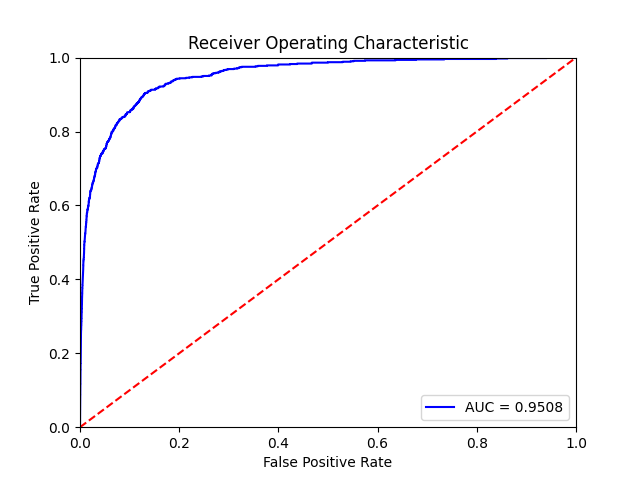

In [83]:
%matplot plt

In [75]:
#Evaluating model performance
#There are inherently mostly NOLABEL so accuracy could be high just bc of those
#Want to make sure that when there is a label besides NOLABEL that it is being accurately predicted


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [88]:
#Model performance metrics
#Assess at individual label level as well as overall

#Accuracy is overall correct predictions - not great measurement tool for imbalanced data
#Precision - TP / TP + FP = spam detection - don't want to mark something as spam (FP) when it isn't
#Recall - TP / TP + FN = sickness - don't want to tell someone they aren't sick (FN) when they are and can spread it
#F1 - balance of precision and recall

#We want to make sure if bomb emoji then it gets marked - even at the expense of marking other things potentially offensive that aren't 
#Important not to have FN - USE RECALL
#Also don't want to be marking a bunch of stuff as offensive when it isn't and making moderation do everything anyway
#Important not to have too many FP - USE PRECISION
#Use F1 for balance between both
print("Accuracy is:  {}" .format(accuracy_score(ytest, y_pred)))
print("Precision is:  {}" .format(precision_score(ytest, y_pred)))
print("Recall is:  {}" .format(recall_score(ytest, y_pred)))
print("F1 Score is:  {}" .format(f1_score(ytest, y_pred)))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Accuracy is:  0.9859
Precision is:  0.6824817518248175
Recall is:  0.23229813664596274
F1 Score is:  0.34661723818350326

In [89]:
#Confusion matrix
confusion_matrix(ytest, y_pred)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

array([[49108,    87],
       [  618,   187]])

In [93]:
tn, fp, fn, tp = confusion_matrix(ytest, y_pred).ravel()
print("tn: {}".format(tn), "fp: {}".format(fp), "fn: {}".format(fn), "tp: {}".format(tp))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

tn: 49108 fp: 87 fn: 618 tp: 187

In [49]:
from pyspark.ml.feature import HashingTF, IDF, Tokenizer

sentenceData = spark.createDataFrame([
    (0.0, "Hi I heard about Spark"),
    (0.0, "I wish Java could use case classes"),
    (1.0, "Logistic regression models are neat"),
    (0.0, "Logistic regression models are dumb")
], ["label", "sentence"])

tokenizer = Tokenizer(inputCol="sentence", outputCol="words")
wordsData = tokenizer.transform(sentenceData)

hashingTF = HashingTF(inputCol="words", outputCol="rawFeatures", numFeatures=20)
featurizedData = hashingTF.transform(wordsData)
# alternatively, CountVectorizer can also be used to get term frequency vectors

idf = IDF(inputCol="rawFeatures", outputCol="features")
idfModel = idf.fit(featurizedData)
rescaledData = idfModel.transform(featurizedData)

rescaledData.select("label", "features").show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  0.0|(20,[0,5,9,17],[0...|
|  0.0|(20,[2,7,9,13,15]...|
|  1.0|(20,[4,6,13,15,18...|
|  0.0|(20,[4,8,13,15,18...|
+-----+--------------------+

In [50]:
rescaledData.show(truncate=False)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----+-----------------------------------+------------------------------------------+-----------------------------------------+----------------------------------------------------------------------------------------------------------------------+
|label|sentence                           |words                                     |rawFeatures                              |features                                                                                                              |
+-----+-----------------------------------+------------------------------------------+-----------------------------------------+----------------------------------------------------------------------------------------------------------------------+
|0.0  |Hi I heard about Spark             |[hi, i, heard, about, spark]              |(20,[0,5,9,17],[1.0,1.0,1.0,2.0])        |(20,[0,5,9,17],[0.9162907318741551,0.9162907318741551,0.5108256237659907,1.8325814637483102])                         |
|0.0  |I

In [51]:
from pyspark.ml.classification import LogisticRegression

# Load training data
training = rescaledData

lr = LogisticRegression(maxIter=3, regParam=0.3, elasticNetParam=0.8)

# Fit the model
lrModel = lr.fit(training)

# Print the coefficients and intercept for logistic regression
print("Coefficients: " + str(lrModel.coefficients))
print("Intercept: " + str(lrModel.intercept))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Coefficients: (20,[6],[0.6599674909832574])
Intercept: -1.1875233653399353

In [52]:
#Show what labels the model predicted
lrModel_2 = lrModel.transform(training)
lrModel_2.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|label|            sentence|               words|         rawFeatures|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|  0.0|Hi I heard about ...|[hi, i, heard, ab...|(20,[0,5,9,17],[1...|(20,[0,5,9,17],[0...|[1.18752336533993...|[0.76629782750481...|       0.0|
|  0.0|I wish Java could...|[i, wish, java, c...|(20,[2,7,9,13,15]...|(20,[2,7,9,13,15]...|[1.18752336533993...|[0.76629782750481...|       0.0|
|  1.0|Logistic regressi...|[logistic, regres...|(20,[4,6,13,15,18...|(20,[4,6,13,15,18...|[0.58280127001373...|[0.64171172349340...|       0.0|
|  0.0|Logistic regressi...|[logistic, regres...|(20,[4,8,13,15,18...|(20,[4,8,13,15,18...|[1.18752336533993...|[0.76629782750481.

In [53]:

trainingSummary = lrModel.summary

# Obtain the objective per iteration
objectiveHistory = trainingSummary.objectiveHistory
print("objectiveHistory:")
for objective in objectiveHistory:
    print(objective)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

objectiveHistory:
0.5623351446188085
0.5501013689318484
0.5421128362877067
0.5315519433187645

In [54]:
print("False positive rate by label:")
for i, rate in enumerate(trainingSummary.falsePositiveRateByLabel):
    print("label %d: %s" % (i, rate))

print("True positive rate by label:")
for i, rate in enumerate(trainingSummary.truePositiveRateByLabel):
    print("label %d: %s" % (i, rate))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

False positive rate by label:
label 0: 1.0
label 1: 0.0
True positive rate by label:
label 0: 1.0
label 1: 0.0

In [55]:
print("Precision by label:")
for i, prec in enumerate(trainingSummary.precisionByLabel):
    print("label %d: %s" % (i, prec))

print("Recall by label:")
for i, rec in enumerate(trainingSummary.recallByLabel):
    print("label %d: %s" % (i, rec))

print("F-measure by label:")
for i, f in enumerate(trainingSummary.fMeasureByLabel()):
    print("label %d: %s" % (i, f))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Precision by label:
label 0: 0.75
label 1: 0.0
Recall by label:
label 0: 1.0
label 1: 0.0
F-measure by label:
label 0: 0.8571428571428571
label 1: 0.0

In [56]:
accuracy = trainingSummary.accuracy
falsePositiveRate = trainingSummary.weightedFalsePositiveRate
truePositiveRate = trainingSummary.weightedTruePositiveRate
fMeasure = trainingSummary.weightedFMeasure()
precision = trainingSummary.weightedPrecision
recall = trainingSummary.weightedRecall
print("Accuracy: %s\nFPR: %s\nTPR: %s\nF-measure: %s\nPrecision: %s\nRecall: %s"
      % (accuracy, falsePositiveRate, truePositiveRate, fMeasure, precision, recall))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Accuracy: 0.75
FPR: 0.75
TPR: 0.75
F-measure: 0.6428571428571428
Precision: 0.5625
Recall: 0.75

In [ ]:
#Train test split - use this over cross fold since it will run quicker even though potentially less accurate results
#Large enough data set should account for not using cross fold

train, test = reviews.randomSplit([0.9, 0.1], seed=12345)
train.show()
train.count()
#884/1000 = 88%